In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip


In [2]:
! pip install pytorch-forecasting pytorch-lightning pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install  neuralforecast --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.6 MB/s eta 0:00:00


In [4]:
KAGGLE_DATA_PATH = "/kaggle/input/walmart-recruiting-store-sales-forecasting/"

In [5]:
import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from datetime import datetime 
import torch 
from neuralforecast.core import NeuralForecast
from neuralforecast.models import DLinear # DLinear model
import os 
import zipfile
from datetime import datetime
# --- Suppress Warnings for cleaner output ---
import warnings
warnings.filterwarnings("ignore")


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset




In [6]:
print("📊 Loading datasets from Kaggle input path...")
        
train_zip_path = os.path.join(KAGGLE_DATA_PATH, 'train.csv.zip')
features_zip_path = os.path.join(KAGGLE_DATA_PATH, 'features.csv.zip')
stores_csv_path = os.path.join(KAGGLE_DATA_PATH, 'stores.csv') 

# --- UNZIP THE FILES ---
print("   📂 Unzipping necessary data files...")
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('.') 
print(f"      - Extracted: {train_zip_path}")
        
with zipfile.ZipFile(features_zip_path, 'r') as zip_ref:
    zip_ref.extractall('.') 
print(f"      - Extracted: {features_zip_path}")

# Now, load the unzipped CSVs (they will be in the current directory, '/kaggle/working/')
_df_train = pd.read_csv('train.csv')
_df_feat = pd.read_csv('features.csv')
_df_store = pd.read_csv(stores_csv_path) 

print(f"📈 Original Train data: {_df_train.shape}")
print(f"📊 Original Features data: {_df_feat.shape}")
print(f"🏪 Original Stores data: {_df_store.shape}")




📊 Loading datasets from Kaggle input path...
   📂 Unzipping necessary data files...
      - Extracted: /kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
      - Extracted: /kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
📈 Original Train data: (421570, 5)
📊 Original Features data: (8190, 12)
🏪 Original Stores data: (45, 3)


In [7]:
df = (
_df_train
.merge(_df_feat, on=['Store','Date','IsHoliday'], how='left')
.merge(_df_store, on='Store', how='left')
)


df['y'] = df['Weekly_Sales'].clip(lower=0)
df['unique_id'] = df['Store'].astype(str) + '_' + df['Dept'].astype(str)

df_nf = df[['unique_id','Date','y']].rename(columns={'Date':'ds'})

In [8]:
class TrainTestDF2NF(BaseEstimator, TransformerMixin):
    def __init__(self, features_df, stores_df):
        self.features_df = features_df
        self.stores_df   = stores_df

    def fit(self, X, y=None):

        return self

    def transform(self, X):
        if set(['unique_id','ds','y']).issubset(X.columns):
            return X


        df_raw = (
            X
            .merge(self.features_df, on=['Store','Date','IsHoliday'], how='left')
            .merge(self.stores_df,   on='Store',            how='left')
        )

        df_raw['y'] = np.nan
        df_raw['unique_id'] = df_raw['Store'].astype(str) + '_' + df_raw['Dept'].astype(str)
        return df_raw[['unique_id','Date','y']].rename(columns={'Date':'ds'})

In [9]:
class DLinearNF(BaseEstimator, RegressorMixin):
    def __init__(self, h, input_size, freq='W-FRI', lr=1e-3, epochs=500, batch_size=64):
        self.h          = h
        self.input_size = input_size
        self.freq       = freq
        self.lr         = lr
        self.epochs     = epochs
        self.batch_size = batch_size

    def fit(self, X, y=None):

        model = DLinear(
            h=self.h,
            input_size=self.input_size,
            learning_rate=self.lr,
            max_steps=self.epochs,
            batch_size=self.batch_size,
            random_seed=42,
            start_padding_enabled=True
        )
        nf = NeuralForecast(models=[model], freq=self.freq)
        nf.fit(df=X)
        self.nf    = nf
        self.model = model
        return self

    def predict(self, X=None):

        preds = self.nf.predict()
        return preds.rename(columns={'DLinear':'y_pred'})

In [10]:
class config:
    horizon = 28
    input_size = 52
    lr = 1e-3
    epochs = 500
    batch_size = 64

In [11]:
_df_feat['Date'] = pd.to_datetime(_df_feat['Date'])
df_nf['ds'] = pd.to_datetime(df_nf['ds'])

# Create cutoff
cutoff = df_nf['ds'].max() - pd.Timedelta(days=28)
train_nf = df_nf[df_nf['ds'] <= cutoff]
val_nf = df_nf[df_nf['ds'] > cutoff]

# Filter features to avoid leakage
features_up_to_cutoff = _df_feat[_df_feat['Date'] <= cutoff]

# Use in pipeline
pipeline = Pipeline([
    ('to_df_nf', TrainTestDF2NF(features_up_to_cutoff, _df_store)),
    ('dlinear', DLinearNF(
        h=config.horizon,
        input_size=config.input_size,
        freq='W-FRI',
        lr=config.lr,
        epochs=config.epochs,
        batch_size=config.batch_size
    ))
])

In [12]:
pipeline.fit(train_nf)
val_preds = pipeline.predict(val_nf)


val_eval = val_nf.merge(val_preds, on=['unique_id','ds'])
holiday_flags = df[['Date', 'IsHoliday']].drop_duplicates()
holiday_flags['Date'] = pd.to_datetime(holiday_flags['Date'])

val_eval = val_eval.merge(holiday_flags, left_on='ds', right_on='Date', how='left')

val_eval['weight'] = val_eval['IsHoliday'].apply(lambda x: 5 if x else 1)


wmae = np.sum(val_eval['weight'] * np.abs(val_eval['y'] - val_eval['y_pred'])) / np.sum(val_eval['weight'])

print(f"Validation WMAE: {wmae:.3f}")

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-07-20 11:38:34.592573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753011514.788105      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753011514.846521      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=500` reached.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Validation WMAE: 1564.401


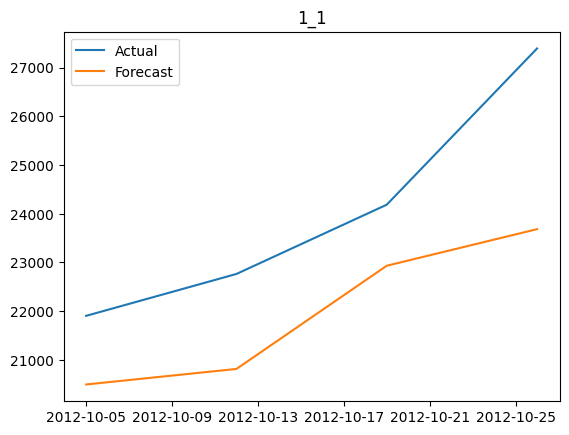

In [13]:
import matplotlib.pyplot as plt

store_dept = '1_1'  
df_plot = val_eval[val_eval['unique_id'] == store_dept]

plt.plot(df_plot['ds'], df_plot['y'], label='Actual')
plt.plot(df_plot['ds'], df_plot['y_pred'], label='Forecast')
plt.title(store_dept)
plt.legend()
plt.show()